In [83]:
import pandas as pd
%load_ext autotime

In [6]:
train = pd.read_csv('train.csv',engine='python')
test = pd.read_csv('test.csv',engine='python')
# after processing some of the texts are emply
train['comment_text'] = train['comment_text'].fillna('')
test['comment_text'] = test['comment_text'].fillna('')
sub = pd.read_csv('sample_submission.csv')

In [9]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [10]:
full_text = list(train['comment_text'].values) + list(test['comment_text'].values)
max_features = 300000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
tk.fit_on_texts(full_text)

In [15]:
embedding_path1 = "crawl-300d-2M.vec"
embedding_path2 = "glove.840B.300d.txt"
embed_size = 300

In [16]:
import numpy as np

In [19]:
from sklearn.model_selection import StratifiedKFold

In [20]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, tokenizer):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    word_index = tk.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# combining embeddings from this kernel: https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution
embedding_matrix = np.concatenate([build_matrix(embedding_path1, tk), build_matrix(embedding_path2, tk)], axis=-1)

y = np.where(train['target'] >= 0.5, True, False) * 1

identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 
                    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['target']:
    train[col] = np.where(train[col] >= 0.5, True, False)

n_fold = 5

folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)

In [72]:
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Input
from keras.layers import Activation, Dense, Embedding, SpatialDropout1D, Flatten, Dropout, concatenate
from keras import initializers, regularizers, constraints, optimizers, layers, Model
from keras.engine.topology import Layer
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from sklearn import metrics
import time

In [73]:
# import keras.layers as L

In [88]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

TOXICITY_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

time: 6.86 ms


In [89]:
# adding attention from this kernel: https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

def build_model(X_train, y_train, X_valid, y_valid, max_len, max_features, embed_size, 
                embedding_matrix, lr=0.0, lr_d=0.0, spatial_dr=0.0,
                dense_units=128, conv_size=128, dr=0.2, patience=3, fold_id=1):
    file_path = "checkpoint/best_model_fold_{}.hdf5".format(fold_id)
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1,save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=patience)
    
    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size * 2, weights=[embedding_matrix], trainable=False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)
    att = Attention(max_len)(x1)
    # from benchmark kernel
    x = Conv1D(conv_size, 2, activation='relu', padding='same')(x1)
    x = MaxPooling1D(5, padding='same')(x)
    x = Conv1D(conv_size, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(5, padding='same')(x)
    x = Flatten()(x)
    x = concatenate([x, att])
    
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_valid, y_valid), 
                        verbose=2, callbacks=[early_stop, check_point])
    return model

# Training fuction

def train_model(X, X_test, y, tokenizer, max_len):
    
    oof = np.zeros((len(X), 1))
    prediction = np.zeros((len(X_test), 1))
    test_tokenized = tokenizer.t
    scores = []exts_to_sequences(test['comment_text'])
    X_test = pad_sequences(test_tokenized, maxlen = max_len)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        valid_df = X_valid.copy()    

        train_tokenized = tokenizer.texts_to_sequences(X_train['comment_text'])
        valid_tokenized = tokenizer.texts_to_sequences(X_valid['comment_text'])

        X_train = pad_sequences(train_tokenized, maxlen = max_len)
        X_valid = pad_sequences(valid_tokenized, maxlen = max_len)
        
        model = build_model(X_train, y_train, X_valid, y_valid, max_len, max_features, embed_size, embedding_matrix,
                            lr = 1e-3, lr_d = 0, spatial_dr = 0.1, dense_units=128, conv_size=128, 
                            dr=0.1, patience=3, fold_id=fold_n)
        
        pred_valid = model.predict(X_valid)
        oof[valid_index] = pred_valid
        valid_df[oof_name] = pred_valid
        
        bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, oof_name, 'target')
        scores.append(get_final_metric(bias_metrics_df, calculate_overall_auc(valid_df, oof_name)))
        
        prediction += model.predict(X_test, batch_size = 1024, verbose = 1)
    
    prediction /= n_fold
    
    # print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, prediction, scores

#Train and predict

oof_name = 'predicted_target'
max_len = 250
oof, prediction, scores = train_model(X=train, X_test=test, y=train['target'], tokenizer=tk, max_len=max_len)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))



Fold 0 started at Tue May 28 12:18:10 2019
Train on 1443899 samples, validate on 360975 samples
Epoch 1/3
 - 1808s - loss: 0.1658 - acc: 0.9412 - val_loss: 0.1566 - val_acc: 0.9439

Epoch 00001: val_loss improved from inf to 0.15664, saving model to checkpoint/best_model_fold_0.hdf5
Epoch 2/3
 - 1807s - loss: 0.1549 - acc: 0.9446 - val_loss: 0.1540 - val_acc: 0.9447

Epoch 00002: val_loss improved from 0.15664 to 0.15399, saving model to checkpoint/best_model_fold_0.hdf5
Epoch 3/3
 - 1807s - loss: 0.1511 - acc: 0.9456 - val_loss: 0.1541 - val_acc: 0.9446

Epoch 00003: val_loss did not improve from 0.15399
97320/97320 [==============================] - 48s 496us/step
Fold 1 started at Tue May 28 13:52:56 2019
Train on 1443899 samples, validate on 360975 samples
Epoch 1/3
 - 1805s - loss: 0.1659 - acc: 0.9413 - val_loss: 0.1555 - val_acc: 0.9442

Epoch 00001: val_loss improved from inf to 0.15550, saving model to checkpoint/best_model_fold_1.hdf5
Epoch 2/3
 - 1804s - loss: 0.1552 - acc: 

In [90]:
scores

[0.8780763861509111,
 0.8782600987367287,
 0.8763849165201163,
 0.8725172735339072,
 0.8784967378807498]

time: 63 ms


In [142]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

time: 2.13 ms


In [135]:
x = train.copy()
x["pred_maybe"] = oof

time: 395 ms


In [136]:
x.loc[x.pred_maybe > 0.5, "target_maybe"] = True
x.target_maybe.fillna(False, inplace=True)

time: 701 ms


In [138]:
f1_score(x["target"],x["target_maybe"])

0.5740202068882424

time: 316 ms


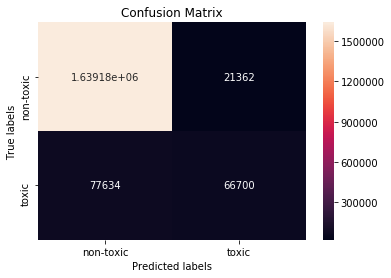

time: 672 ms


In [139]:
cm = confusion_matrix(x["target"],x["target_maybe"])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
plt.show()

In [140]:
accuracy_score(x["target"],x["target_maybe"])

0.9451507418246371

time: 78.5 ms


In [143]:
precision_score(x["target"],x["target_maybe"])

0.7574209079966387

time: 308 ms


In [145]:
recall_score(x["target"],x["target_maybe"])

0.4621225768010309

time: 309 ms


In [141]:
roc_auc_score(x["target"],x["target_maybe"])

0.724629043468144

time: 264 ms
